In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [24]:
# Load the preprocessed dataset
preprocessed_file_path = 'preprocessed_telco_customer_churn.csv'
preprocessed_df = pd.read_csv(preprocessed_file_path)

# Label encode the 'Churn' column
preprocessed_df['Churn'] = preprocessed_df['Churn'].map({'Yes': 1, 'No': 0})


In [25]:
# One-hot encode the categorical variables
preprocessed_df = pd.get_dummies(preprocessed_df)

In [ ]:
# Visualize the correlation matrix
plt.figure(figsize=(18, 16))
sns.heatmap(preprocessed_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Visualize the distribution of numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(preprocessed_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()

In [ ]:
# Visualize the distribution of categorical features
categorical_features = [col for col in preprocessed_df.columns if col not in numerical_features + ['Churn_Yes', 'Churn_No']]

for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=preprocessed_df[feature], hue=preprocessed_df['Churn_Yes'])
    plt.title(f'Distribution of {feature} by Churn')
    plt.xticks(rotation=45)
    plt.show()

In [26]:
# Split the data
X = preprocessed_df.drop(['Churn'], axis=1)
y = preprocessed_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [27]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [28]:
# Select a machine learning algorithm
clf = RandomForestClassifier(random_state=42)

In [31]:
# Perform cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.87784679 0.85024155 0.8447205  0.86335404 0.85220994]
Mean cross-validation score: 0.8576745631393722


In [32]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
best_params = grid_search.best_params_

print("Best parameters found:", best_params)


Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [33]:
# Train the model using the optimized hyperparameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(min_samples_split=10, n_estimators=300, random_state=42)

In [34]:
# Display feature importances
feature_importances = best_clf.feature_importances_
importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importances_df = importances_df.sort_values('importance', ascending=False)

print("Feature importances:")
print(importances_df)

Feature importances:
                                    feature  importance
36                  Contract_Month-to-month    0.115038
3                              TotalCharges    0.085749
18                        OnlineSecurity_No    0.082855
1                                    tenure    0.082775
43           PaymentMethod_Electronic check    0.078563
27                           TechSupport_No    0.058877
2                            MonthlyCharges    0.057627
21                          OnlineBackup_No    0.038662
40                     PaperlessBilling_Yes    0.036613
16              InternetService_Fiber optic    0.036517
24                      DeviceProtection_No    0.029246
6                                Partner_No    0.022045
38                        Contract_Two year    0.021180
8                             Dependents_No    0.018356
7                               Partner_Yes    0.013442
5                               gender_Male    0.012592
14                        M

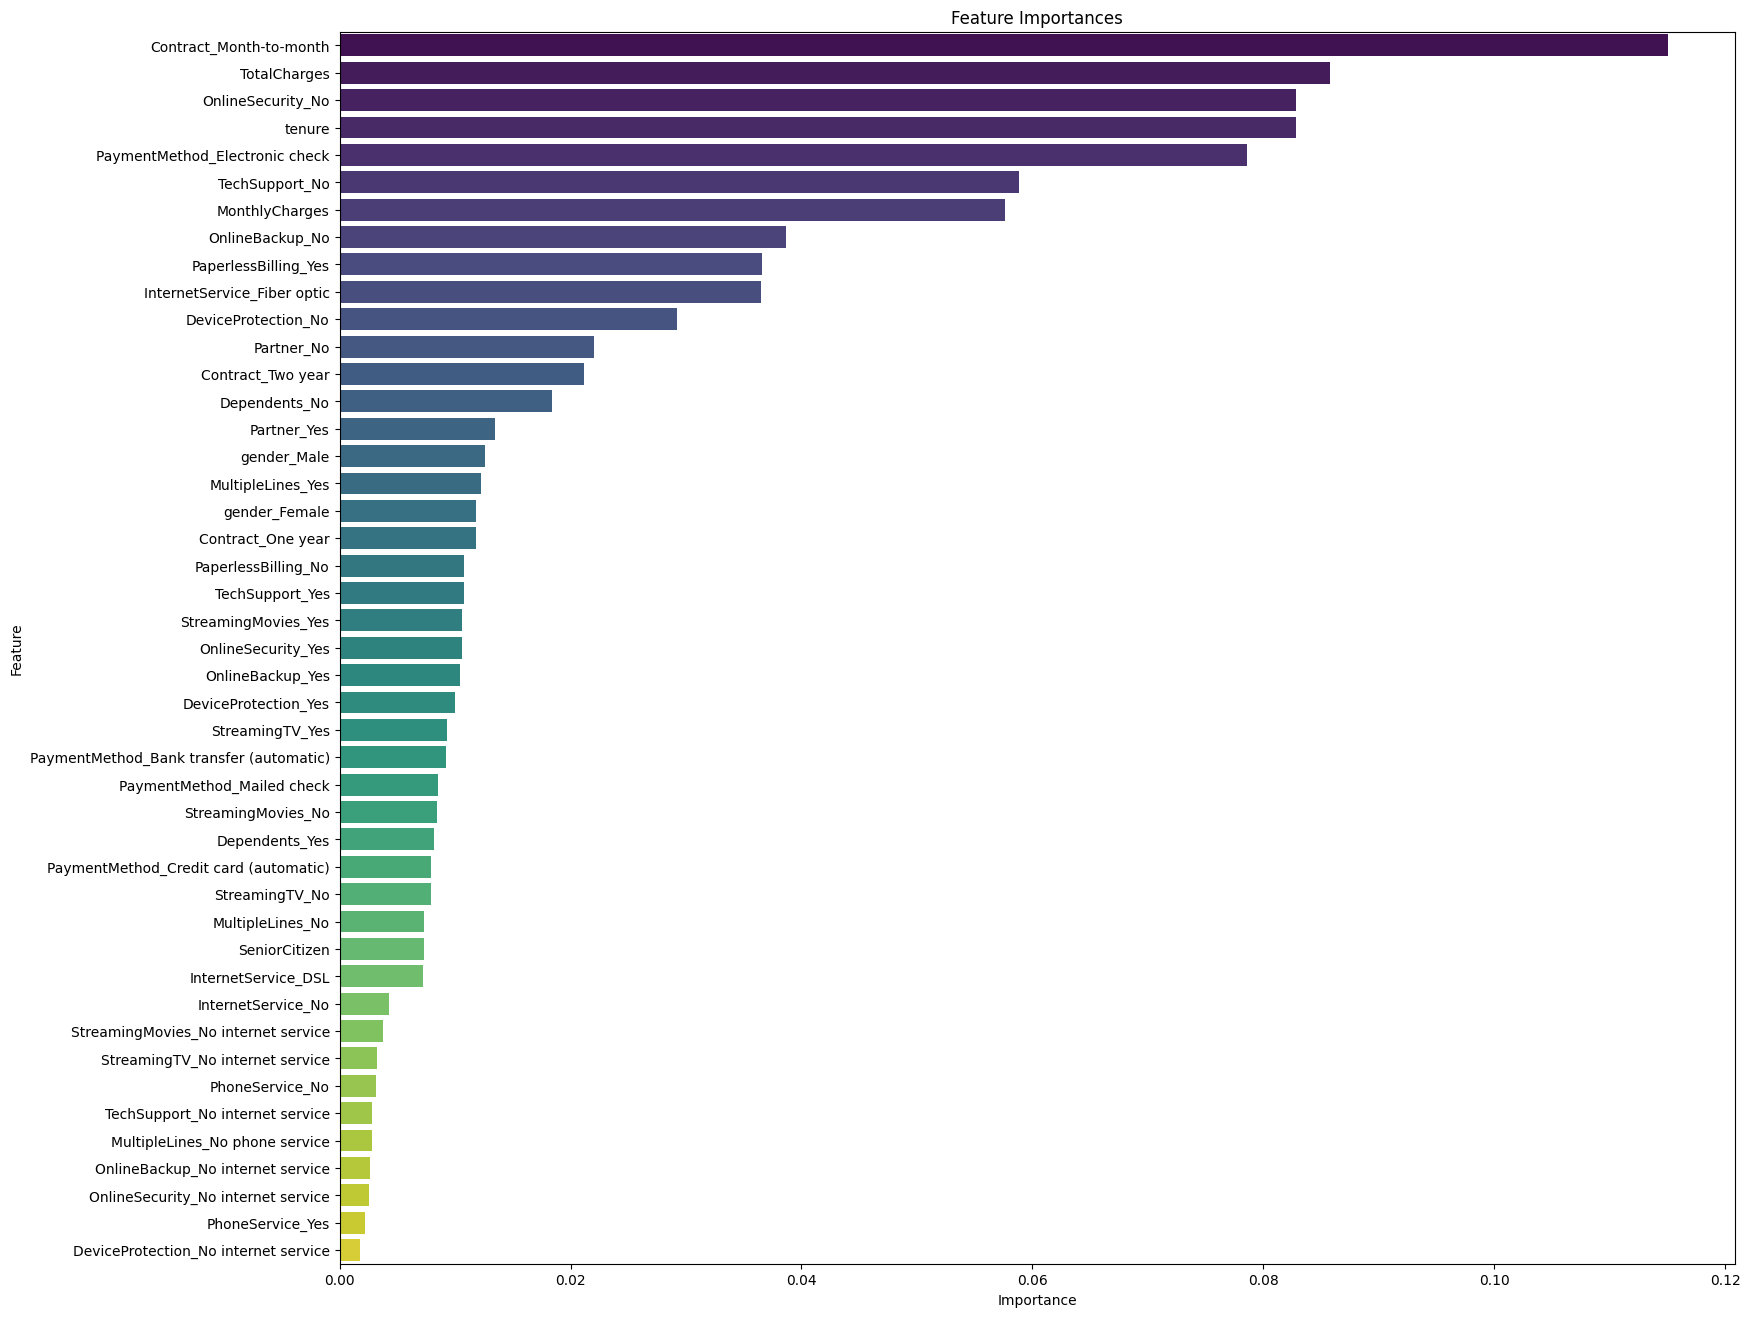

In [36]:
# Visualize feature importances
plt.figure(figsize=(18,16))
sns.barplot(x='importance', y='feature', data=importances_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()